Deep Lerning Kurs 1 - GTSRB Hello World
=======================================

Dieses Notebook stellt den German Traffic Sign Recognition Benchmark in Python / Keras vor und adaptiert das *ResNet50* Deep-Lerning-Modell auf diese Aufgabe.

Das Benchmarkproblem wurde vorgeschlagen in:
J. Stallkamp, M. Schlipsing, J. Salmen, C. Igel: *Man vs. computer: Benchmarking machine learning algorithms for traffic sign recognition*, Neural Networks, http://dx.doi.org/10.1016/j.neunet.2012.02.016 

Diese Anleitung ist Copyright (c) 2017 Thomas Viehmann, http://lernapparat.de/.
Dieses Notebook wie der Code steht unter der MIT Lizenz.
Dieses Notebook gehört zum ersten Teil des Deep-Learning-Kurses: http://lernapparat.de/artikel/dlkurs01 hat weitere Informationen, Links etc.

Zur Vorbereitung greifen wir die Python-Werkzeugkiste:

In [1]:
%matplotlib inline
import keras
from sklearn.metrics import confusion_matrix
import GTSRB_utils

Using TensorFlow backend.


Als erstes Laden wir die Bilder mit den Schildern. Beim ersten Benutzen werden sie (348MB) aus dem Internet heruntergeladen und im Keras-Datasets-Ordner abgelegt. Dies geschiet mit dem Modul (`GTSRB_data`), dass dem entsprechenden Keras-Modul für den MNIST-Datensatz nachempfunden ist.

Um mit ResNet50 (einem Modell für ImageNet-Bilder) zu arbeiten, werden alle Bilder auf das ImageNet-Format (224x224) (meist hoch-) skaliert. (Später, wenn wir eigene Modelle bauen, benutzen wir deutlich kleinere Formate.) 

Aber nun die Daten: 

In [2]:
images, labels, val_images, val_labels, test_images, test_labels = GTSRB_utils.get_GTSRB_data()

Extracting training images
39209/39209 [==============================] - 14s    

Extracting test images
12630/12630 [==============================] - 4s     




Und wie sehen sie aus? Schauen wir mal ins Trainings-Set:

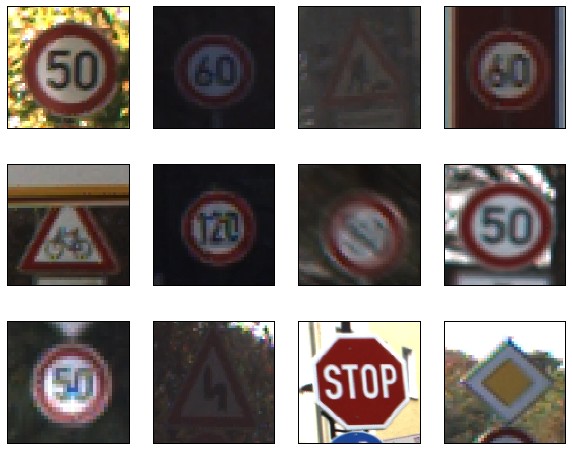

In [3]:
GTSRB_utils.plot_sample(images)

Soweit so gut. Jetzt soll ja aber der Computer etwas damit machen.
Wir benutzen ein von Keras vorgefertigtes Modell, das ResNet50-Modell [He et al: Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385). (Beim ersten Ausführen lädt Keras knapp 100MB an Parametern herunter.)

(Sollte man den Kernel aus Speichergründen neu starten müssen, kann man diese und die nächste Zeile überspringen...)

In [4]:
p = GTSRB_utils.predict_resnet50(images[:10])
p

array([[  2.57127685e-05,   1.18177650e-05,   2.13176293e-07, ...,
          8.33909212e-07,   4.03314880e-05,   5.43987007e-05],
       [  4.67326299e-06,   4.85019955e-05,   4.59407374e-07, ...,
          6.32083265e-06,   4.04526145e-05,   4.10271332e-06],
       [  1.35469390e-05,   6.87812208e-05,   1.16614428e-05, ...,
          3.26366990e-06,   3.67607863e-05,   2.50050449e-04],
       ..., 
       [  8.08761888e-06,   2.71496276e-04,   1.78063492e-05, ...,
          7.79164111e-06,   2.28548688e-05,   2.96203361e-04],
       [  1.16114745e-06,   2.86030463e-05,   1.42069979e-07, ...,
          6.08578875e-06,   2.40211248e-05,   7.28845698e-05],
       [  6.25767711e-07,   5.93859659e-06,   3.33673370e-07, ...,
          1.54158911e-07,   3.18871525e-06,   2.10957485e-04]], dtype=float32)

So einfach kann also Deep Learning sein!

Aber Moment, die Vektoren aus kleinen Zahlen müssen wir noch entschlüsseln. Lassen wir uns die drei besten Vorschläge des Modells mit ihrem Gewicht ausgeben.

[[('gong', 0.22253929),
  ('loudspeaker', 0.21163763),
  ('dial_telephone', 0.14450847)],
 [('hog', 0.16092367),
  ('Sussex_spaniel', 0.14291501),
  ('three-toed_sloth', 0.071406111)],
 [('cassette', 0.27091751),
  ('loupe', 0.15143377),
  ('loudspeaker', 0.064648934)],
 [('loudspeaker', 0.39450383),
  ('traffic_light', 0.13302745),
  ('police_van', 0.066399552)],
 [('bottlecap', 0.15742801),
  ('loupe', 0.15402587),
  ('street_sign', 0.14849198)],
 [('gas_pump', 0.20782977),
  ('thimble', 0.066109069),
  ('cassette', 0.066029653)],
 [('birdhouse', 0.53785783),
  ('window_screen', 0.16668211),
  ('bell_cote', 0.039782546)],
 [('jellyfish', 0.28003442),
  ('loudspeaker', 0.11570058),
  ('traffic_light', 0.081306338)],
 [('loudspeaker', 0.43758512),
  ('hard_disc', 0.14136842),
  ('loupe', 0.096494384)],
 [('loudspeaker', 0.86334383),
  ('cassette_player', 0.040692098),
  ('iPod', 0.027179468)]]

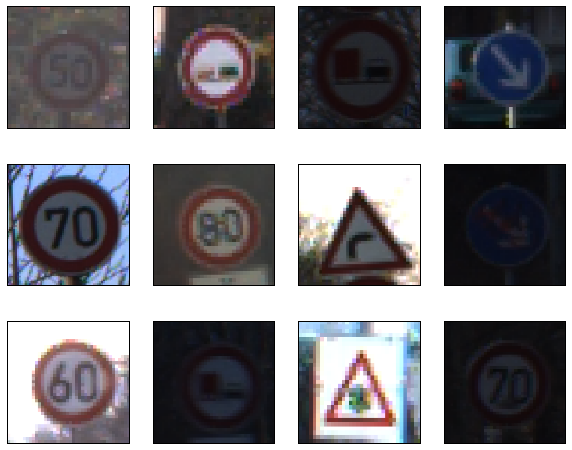

In [5]:
GTSRB_utils.plot_sample(images, shuffle=False, num=12)
GTSRB_utils.decode_predictions(p,top=3)

Überwiegend werden runde Dinge erkannt, manchmal sogar Straßenschilder. *Flaschendeckel* als Tipp für etwas, das Rund  mit Zeichen darauf ist, ist ja auch nicht schlecht. Manche anderen Zeichen werden für eine digitale Uhr gehalten. Für Verkehrsschilderkennung ist das so jedoch nicht geeignet. 

Aber wir wollen ja auch unser eigenes Modell bauen.

Das ResNet50-Modell kann wie viele Modelle zur Bilderkennung vereinfacht in zwei Teile zerlegt werden, einen, der Eigenschaften aus den Bildern "extrahiert" und einen, der auf Basis dieser Eigenschaften die Klassifikation vornimmt. Wir nehmen den ersten Teil und berechnen schonmal die Eigenschaften (Features) auf Trainings- und Test-Daten. Diese wollen wir dann statt der Bilder selbst in unser Modell stecken. Die Feature-Berechnung benötigt eine ganze Weile (bei mir etwa 1,5 Stunden), daher werden die Features nur einmal berechnet und dann in einer Datei gespeichert und ab dann von dort verwendet. Diese Cache-Datei wird ca. 415MB groß.

In [3]:
features, val_features, test_features = GTSRB_utils.get_resnet50_preprocessed(images, val_images, test_images)

Precalculating last layer from ResNet50.
12630/12630 [==============================] - 1299s  


So, jetzt fehlt uns nur noch die zweite Hälfte.
Schauen wir zuerst die Labels an:

In [4]:
labels[:5]

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.],
       [

Es sind also one-hot-encoded Labels: Für jede der 43 Arten von Schildern gibt es eine Spalte, eine 1 dort zeigt an, dass es sich um eben ein solches Schild handelt. Also benötigen wir eine Version der zweiten Hälfte des ResNet50-Modells, die 43 Klassen kennt (statt der 1000 des ImageNet-Recognition-Challenges). Die Anzahl der Spalten wird unten als `labels.shape[1]` festgelegt.


In [5]:
m = GTSRB_utils.get_resnet50_top(labels.shape[1])

Lernen ist die Minimierung einer Zielfunktion (hier nur die `categorical_cross_entropy` - später mehr dazu). In Keras macht man das mit zwei Zeilen. Eine Zahl, die vom Himmel fällt, ist die Learning Rate `lr`.

In [6]:
m.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = m.fit(features,labels, validation_data=(val_features,val_labels),nb_epoch=50)

Train on 35789 samples, validate on 3420 samples
Epoch 1/50
35789/35789 [==============================] - 7s - loss: 1.7119 - acc: 0.5323 - val_loss: 1.3272 - val_acc: 0.6009
Epoch 2/50
35789/35789 [==============================] - 7s - loss: 0.8425 - acc: 0.7753 - val_loss: 1.0756 - val_acc: 0.6696
Epoch 3/50
35789/35789 [==============================] - 7s - loss: 0.6125 - acc: 0.8438 - val_loss: 0.9812 - val_acc: 0.6936
Epoch 4/50
35789/35789 [==============================] - 7s - loss: 0.4854 - acc: 0.8809 - val_loss: 0.9288 - val_acc: 0.7035
Epoch 5/50
35789/35789 [==============================] - 7s - loss: 0.4025 - acc: 0.9058 - val_loss: 0.9084 - val_acc: 0.7108
Epoch 6/50
35789/35789 [==============================] - 7s - loss: 0.3439 - acc: 0.9215 - val_loss: 0.8680 - val_acc: 0.7249
Epoch 7/50
35789/35789 [==============================] - 7s - loss: 0.2999 - acc: 0.9341 - val_loss: 0.8404 - val_acc: 0.7371
Epoch 8/50
35789/35789 [==============================] - 7s -

Die Erkenngenauigkeit auf dem Validierungs-Set `val_acc` ist die wichtige Größe: Sie misst, welchen Anteil der Verkehrszeichen des Validierungs-Datensatzes, auf denen das Modell nicht trainiert wurde, es erkennen kann. (Falls `acc` sich nicht ändert, ist entweder etwas mit der Lernrate oder sogar mit dem Modell falsch.) Unsere Erwartung ist, dass gleich die Genauigkeit auf dem Test-Set ähnlich sein wird. 77% ist besser als nichts, aber jedes vierte Verkehrszeichen falsch zu erkennen, bleibt wohl hinter dem, was von einem Fahrschüler erwartet wird, zurück, und liegt auch weit hinter den 99.5% des Gewinnerteams und den 95%, die 2011 für eine Platzierung in den Top 5 genügt hätte.
Den Verlauf der Erkenngenauigkeit über die Durchläufe können wir übrigens auch anzeigen:

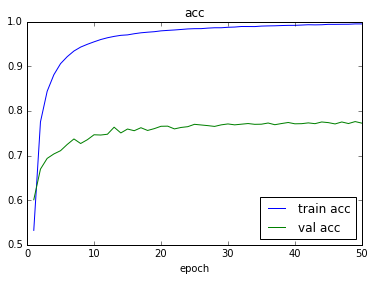

In [7]:
GTSRB_utils.plot_history(history)

Wir sehen, dass die Validierungs-Genauigkeit relativ schnell bis ca. 75% steigt und dann aber nur noch sehr langsam und nicht monoton wächst. 

Wo macht das Modell eigentlich Fehler? Gucken wir uns die Vorhersagen genauer an. (Es wird ja je ein Vektor mit "Wahrscheinlichkeiten" ausgegeben, mit argmax(1) legen wir uns in jeder Zeile (also bei jedem Bild) auf die vermutete Klasse fest.)

In [8]:
test_predictions = m.predict(test_features)
# die für am wahrscheinlichsten gehaltenen Klassen
test_predicted_classes = test_predictions.argmax(1)
test_label_classes     = test_labels.argmax(1)
print ("Accuracy:",(test_label_classes==test_predicted_classes).mean())

Accuracy: 0.800712589074


So kann man die Genauigkeit bestimmen. Um zu sehen, welche Verwechselungen am häufigsten waren, können wir die Konfusions-Matrix (bei Wikipedia wird Confusion Matrix als Wahrheitsmatrix übersetzt, aber Konfusion scheint mir treffender). Wir können uns die häufigsten Verwechselungen anzeigen lassen. (Dabei verwenden wir als Notation *Wahre Klasse* $\rightarrow$ *Vorhersage* (*Anzahl*).)

In [9]:
cm = confusion_matrix(test_label_classes,test_predicted_classes)
print (GTSRB_utils.maximal_confusion_str(cm))

30->50 (123)
50->30 (102)
120->80 (72)
70->50 (63)
Gebot: Rechts->Gebot: Links (61)
60->80 (56)
100->120 (52)
50->80 (47)
Gebot: Links vorbei->Gebot Rechts vorbei (47)
60->30 (45)


Die häufigsten Fehler sind also:
- Das Modell erkennt eine Geschwindigkeitsbegrenzung, liest aber die falsche Zahl. Das mag daran liegen, dass das ResNet50-Basismodell nicht zur Erkennung von Zahlen gemacht ist.
- Das Modell hat offenbar ausgeprägte Schwierigkeiten, rechts von links zu unterscheiden. Auch hier liegt die Erklärung vermutlich im ursprünglichen Verwendungszweck und dem Training: Die ResNet50-Autoren haben beim Training des Modells die Trainings-Bilder zufällig horizontal gespiegelt. (Wir lernen diese *Data-Augmentation* genannte Technik, die immer knappen Trainingsdaten anzureichern, später kennen.) Das Modell ist also gewissermaßen darauf trainiert, ein Bild und sein Spiegelbild für gleich zu halten. 

Wir können auch die Konfusionsmatrix komplett ausgeben.

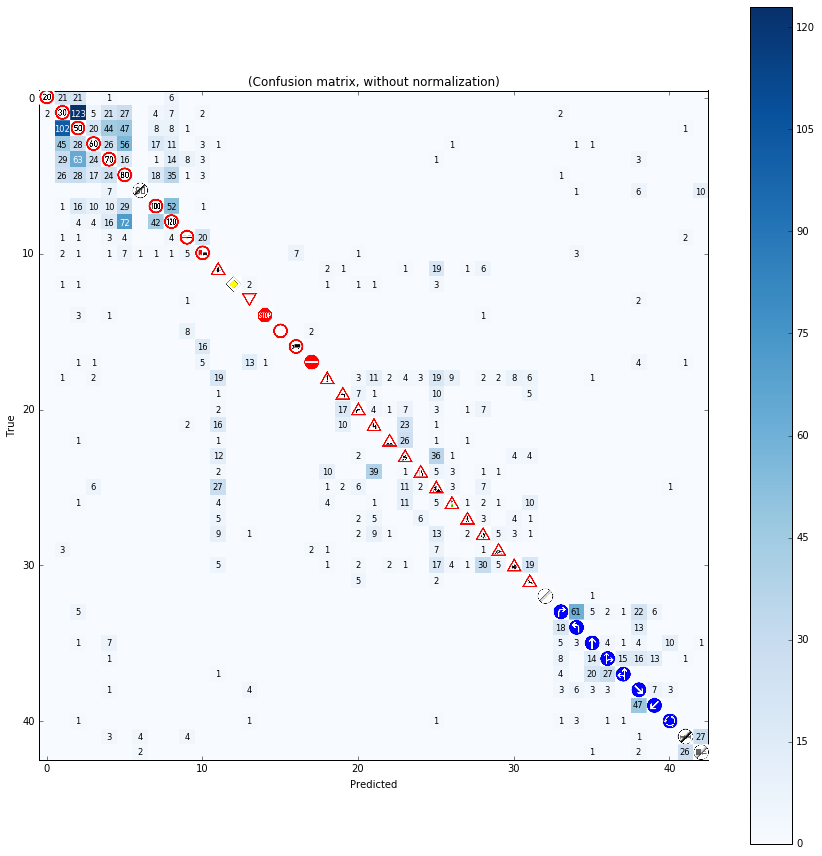

In [10]:
GTSRB_utils.plot_confusion_matrix(cm)

Verwechselungen zwischen den Klassen (Richtungs-Gebote, Geschwindigkeits- und Überholbegrenzungen, Warnschilder) sind selten, innerhalb der Klassen ist das Modell aber nicht sehr genau.

Schließlich können wir uns einige falsch klassifizierte Bilder ansehen:

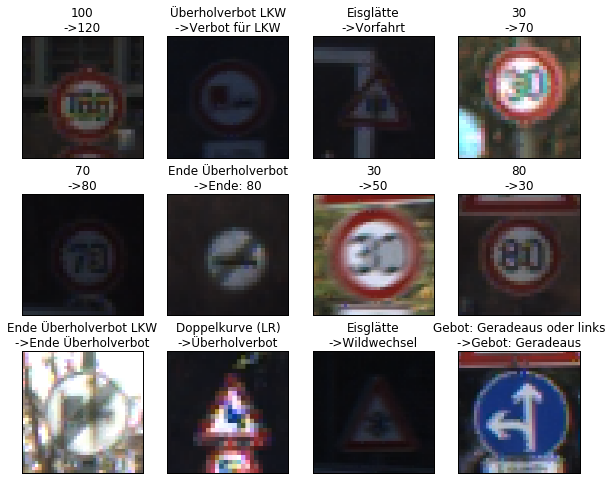

In [14]:
GTSRB_utils.plot_errors(test_predictions, test_labels, test_images)

Nun ist Zeit zum Experimentieren. Hier einige Vorschläge:
- Für alle GTSRB_utils-Funktionen, die hier verwendet werden, sind Beschreibungen hinterlegt, die man mit `? GTSRB_utils.<funktion>` anzeigen lassen kann. Oft gibt es zusätzliche Parameter, wie Anzahlen bei den Analysefunktionen.
- Mit `?? GTSRB_utils.<funktion>` kann man den Quellcode der Funktionen anzeigen (oder man kann ihn in GTSRB_utils.py ansehen). Für einige Funktionen - vor allem denen mit den neuronalen Netzen wie `GTSRB_utils.get_resnet50_top` ist es sinnvoll, die Definition anzusehen und eventuell direkt in das Notebook einzubauen. 
- Werden die Ergebnisse mit mehr Trainingsdurchläufen (`nb_epoch` im `fit`-Aufruf) besser?
- Was passiert, wenn man die Lernrate im `fit`-Aufruf ändert (ruhig auch mal *sehr* große und kleine Werte wie 1000 oder 0.0000001 probieren)? Lohnt es sich erst einige Durchläufe mit einer höheren, dann mit einer niedrigeren Lernrate zu machen?
- Die `fit`-Funktion hat auch einen `validation_split`-Parameter, der es erlaubt, aus dem Trainingsdatensatz den Validierungsdatensatz beim Aufruf zurückzulegen. Dazu wird `validation_data=...` durch `validation_split=0.1` (für 10% Validierungs-Daten) ersetzt. Was passiert und warum?
- Im Modul gibt es eine Funktion für ein Zwei-Schichten-Klassifikationsmodell `get_resnet50_two_layer_top`. Was ändert sich mit zwei Schichten?


Eine ausführlichere Beschreibung und auch eine Fortsetzung, bei der wir über 95% Genauigkeit kommen, folgt auf http://lernapparat.de/dlkurs01 .